# Теперь давайте соберём из кусочков модель.

Экспериментировать будем на примере подмножества классического датасета для классификации картинок: ImageNet. Tiny ImageNet содержит 100_000 цветных изображений, разделённых на 200 классов (по 500 для каждого класса) и уменьшенных до 64×64. Внутри у него примерно такое:

<img src='tiny-imagenet/test/images/test_1.JPEG' width=128/>
<img src='tiny-imagenet/test/images/test_2.JPEG' width=128/>
<img src='tiny-imagenet/test/images/test_3.JPEG' width=128/>
<img src='tiny-imagenet/test/images/test_4.JPEG' width=128/>
<img src='tiny-imagenet/test/images/test_5.JPEG' width=128/>
<img src='tiny-imagenet/test/images/test_6.JPEG' width=128/>
<img src='tiny-imagenet/test/images/test_7.JPEG' width=128/>
<img src='tiny-imagenet/test/images/test_8.JPEG' width=128/>


Загрузить датасет `tiny-imagenet-200.zip` можно [с Каггла](https://www.kaggle.com/datasets/nikhilshingadiya/tinyimagenet200)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
from torch import nn
from torchvision import transforms
from time import time
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import time
import torch, torch.nn as nn
from IPython.display import clear_output
%matplotlib inline

## Данные

In [2]:
class TestDataset(Dataset):
    def __init__(self, csv_file, root, transform=None):
        self.info = pd.read_csv(csv_file, sep='\t', header=None)
        self.root = root
        self.transform = transform
        classes = pd.read_csv('tiny-imagenet/wnids.txt', sep='\t', header=None).sort_values(0).reset_index(drop=True)
        self.classes_dict = {classes[0][i]:i for i in range(200)} # class id to class

    def __len__(self):
        return len(self.info)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root, self.info.iloc[idx, 0])
        image = np.asarray(Image.open(img_name).convert('RGB'))
        target = self.classes_dict[self.info.iloc[idx, 1]]

        if self.transform:
            image = self.transform(image)

        return image, target


In [3]:
transform_train = transforms.Compose([ # аугментации!
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

dataset = torchvision.datasets.ImageFolder('tiny-imagenet/train', transform=transform_train)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [80000, 20000])
test_dataset  = TestDataset(csv_file='tiny-imagenet/val/val_annotations.txt',
                          root='tiny-imagenet/val/images',   
                          transform=transform_test)

In [4]:
batch_size = 64
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2),
    'val'  : DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=2),
    'test' : DataLoader(test_dataset,  batch_size=batch_size, shuffle=True, num_workers=2) 
}

## Modelling

In [5]:
# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Accuracy(nn.Module):
    def __init__(self):
        super(Accuracy, self).__init__()

    def forward(self, outputs, targets):
        return torch.mean((outputs == targets).double())

In [6]:
def block(cin, cout, kernel_size=(3,3), padding=(1,1), stride=(1,1), pool_size=(2,2)):
    return nn.Sequential(
        nn.Conv2d(in_channels=cin, 
                  out_channels=cout, 
                  kernel_size=kernel_size, 
                  padding=padding, 
                  stride=stride),
        nn.BatchNorm2d(num_features=cout),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=pool_size)
    )

class ConvClassifier(nn.Module):
    def __init__(self, input_channels, hidde_size, num_classes: int = 200, dropout: float = 0.5) -> None:
        super().__init__()
        self.blocks = nn.Sequential(
            block(cin=input_channels, 
              cout=hidde_size),
            block(cin=hidde_size, 
                cout=hidde_size*2),
            nn.Dropout(0.2),
            block(cin=hidde_size*2, 
                cout=hidde_size*4),
            block(cin=hidde_size*4, 
                cout=hidde_size*8),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(in_features=hidde_size*8*4*4, 
                    out_features=hidde_size*16),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=hidde_size*16, 
                    out_features=num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.blocks(x)

## Training

In [7]:
def train_epoch(model, dataloader, criterion, metric, device, optimizer):
    total_loss = 0
    total_acc  = 0
    n = len(dataloader) 
    model.train(True)
    for X_batch, y_batch in dataloader:
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        X_batch.requires_grad = True
        out = model(X_batch)

        loss = criterion(out, y_batch)
        loss.backward()
        total_loss += loss.item()

        _, y_preds = torch.max(out, 1)
        total_acc += metric(y_preds, y_batch).item()

        optimizer.step()
        optimizer.zero_grad()


    av_loss = total_loss / n
    av_acc  = total_acc  / n

    return av_loss, av_acc

In [8]:
@torch.no_grad()
def eval_model(model, dataloader, metric, device):
    total_acc = 0
    n = len(dataloader)  
    
    model.eval()
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
 
        out = model(X_batch)
        _, y_preds = torch.max(out, 1)
        total_acc += metric(y_preds, y_batch).item()
        
 
    av_acc = total_acc / n
 
    return av_acc

In [9]:
@torch.no_grad()
def get_result(model, dataloader, device): 
    answer = torch.empty(0)

    model.eval()
    for X_batch, _ in dataloader:
        X_batch = X_batch.to(device)
 
        out = model(X_batch)

        answer = torch.cat([answer, out.argmax(-1).to('cpu')])

    return answer

In [10]:
def draw_accuracy(log):
    clear_output(True)
    np_log = np.array(log)
    plt.title("Accuracy")
    plt.plot(np_log[:, 0], label='train')
    plt.plot(np_log[:, 1], label='val')
    plt.grid()
    plt.legend()
    plt.show()


In [11]:
def train_model(model, dataloaders, optimizer,
                criterion=nn.CrossEntropyLoss(), 
                metric=Accuracy(), 
                device=torch.device("cuda:0" if torch.cuda.is_available() else 'cpu'), 
                epochs=50):
    os.makedirs('ckpts', exist_ok=True)
    model.to(device), 
    log_acc = []
    for epoch in range(epochs):
        start_time = time.time()
        
        loss, train_acc =  train_epoch(model, dataloaders['train'], criterion, metric, device, optimizer)   
        
        val_acc  =         eval_model(model, dataloaders['val'], metric, device)

        log_acc.append((train_acc, val_acc))
        
        draw_accuracy(log_acc)
 
        print("Epoch [{}/{}] Time: {:.2f}s; TrainLoss: {:.4f}; TrainAccuracy: {:.4f}; ValAccuracy: {:.4f}".format(
              epoch + 1, epochs, time.time() - start_time, loss, train_acc, val_acc))
        
        if epoch % 4 == 3:
            torch.save(model.state_dict(), f'ckpts/{epoch}.ckpt')
    
    return model, val_acc

# Обучение модели

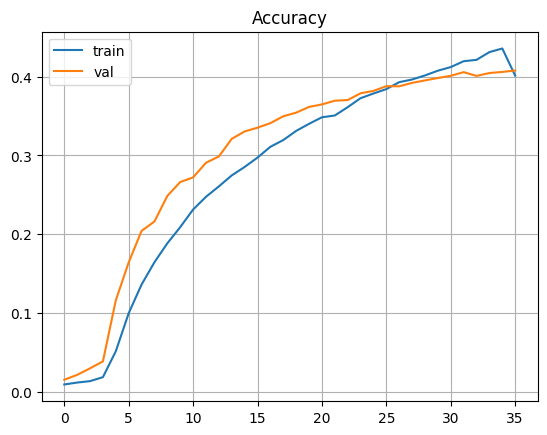

Epoch [36/50] Time: 17.99s; TrainLoss: 2.7570; TrainAccuracy: 0.4013; ValAccuracy: 0.4078


In [ ]:
torch.cuda.empty_cache()
model = ConvClassifier(input_channels=3, hidde_size=64, num_classes=200, dropout=0.5)

for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trained_model, val_accuracy = train_model(
    model=model, 
    dataloaders=dataloaders, 
    optimizer=optimizer, 
    epochs=50
)

# Получение результата

In [ ]:
model_test = ConvClassifier(input_channels=3, hidde_size=64, num_classes=200, dropout=0.5)
model_test.load_state_dict(torch.load('ckpts/35.ckpt'))

<All keys matched successfully>

In [ ]:
criterion=nn.CrossEntropyLoss(), 
metric=Accuracy()
device=torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
model_test.to(device)
test_acc = eval_model(model_test, dataloaders['test'], metric, device)
test_acc


/home/alexander/Desktop/ml2024/ml2023/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:153: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/home/alexander/Desktop/ml2024/ml2023/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:153: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of w

0.4241640127388535

# А что происходит в современном CV?

Давайте посмотрим на другую задачку: детекцию объектов на изображении, на примере [статьи](https://arxiv.org/pdf/1506.02640v5) об архитектуре YOLO. 

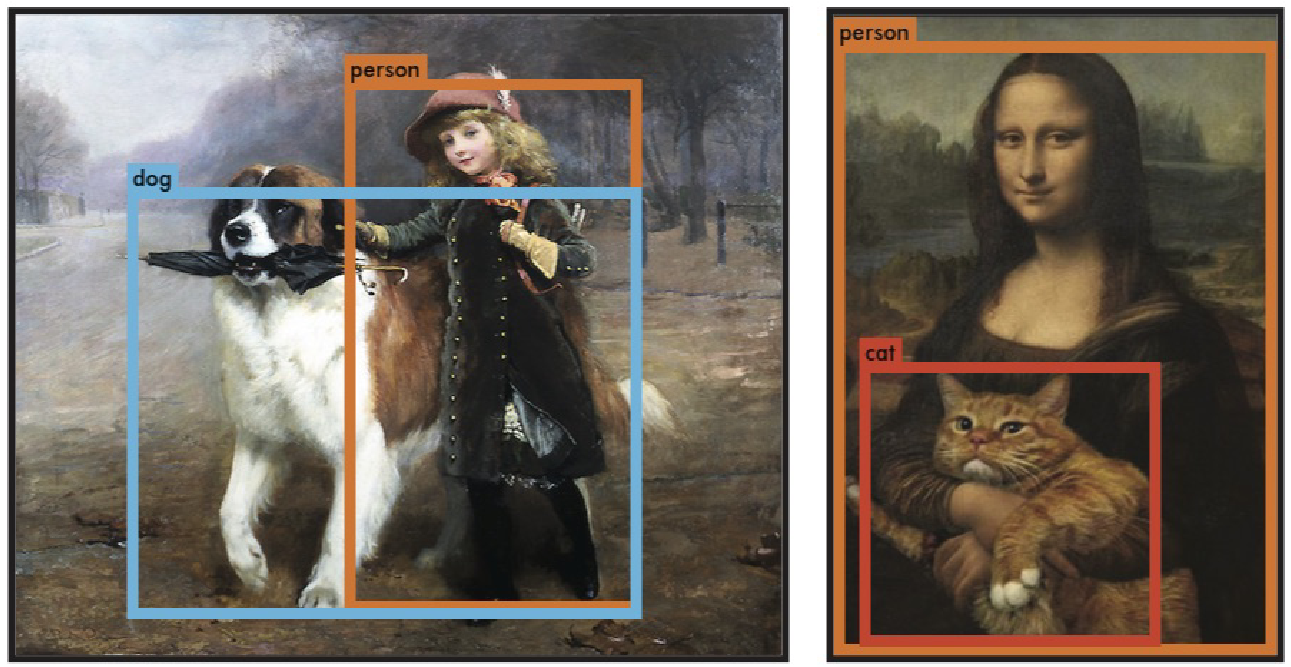

Архитектура выглядит примерно так:

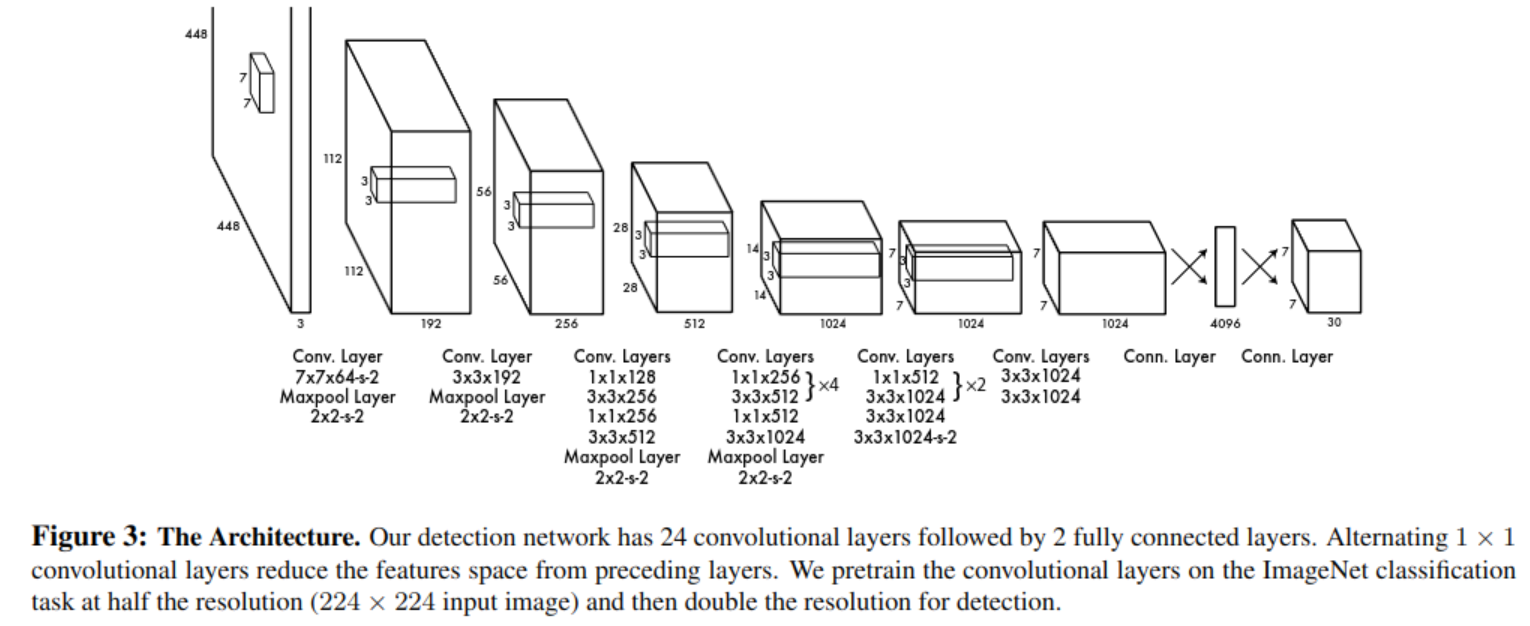

А идея того, как оно находит объекты - вот:

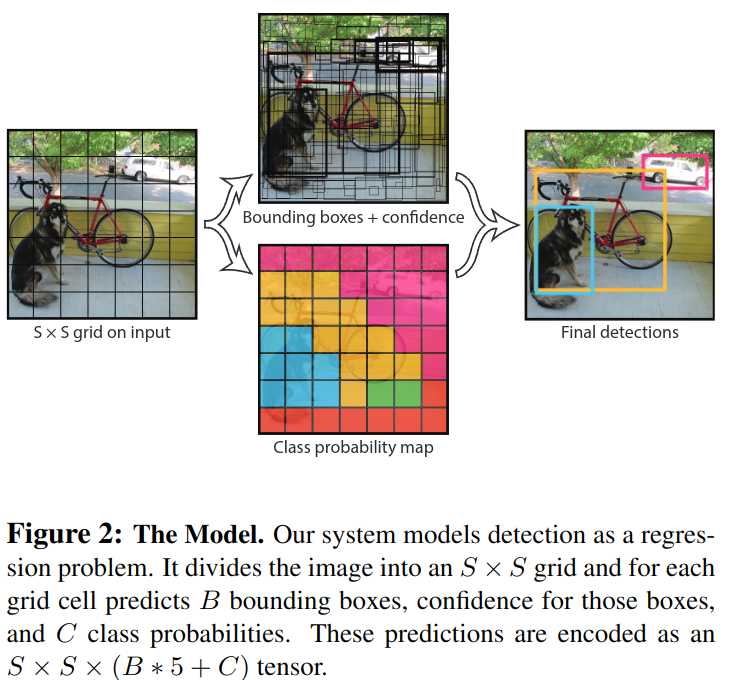

В этот раз встанем на плечи гигантов и возьмём предобученную модель, описанную в https://pytorch.org/hub/ultralytics_yolov5/

In [ ]:
!pip install -q -U ultralytics

Using cache found in /home/alexander/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-5-6 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3090 Ti, 24219MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


         xmin        ymin         xmax        ymax  confidence  class    name
0  742.209778   47.850616  1141.138916  717.344971    0.879852      0  person
1  441.971527  437.209290   496.340851  709.998596    0.686640     27     tie
2  124.956116  193.362854   710.672424  714.437927    0.684337      0  person
3  982.970947  308.322479  1027.341553  420.164093    0.267306     27     tie


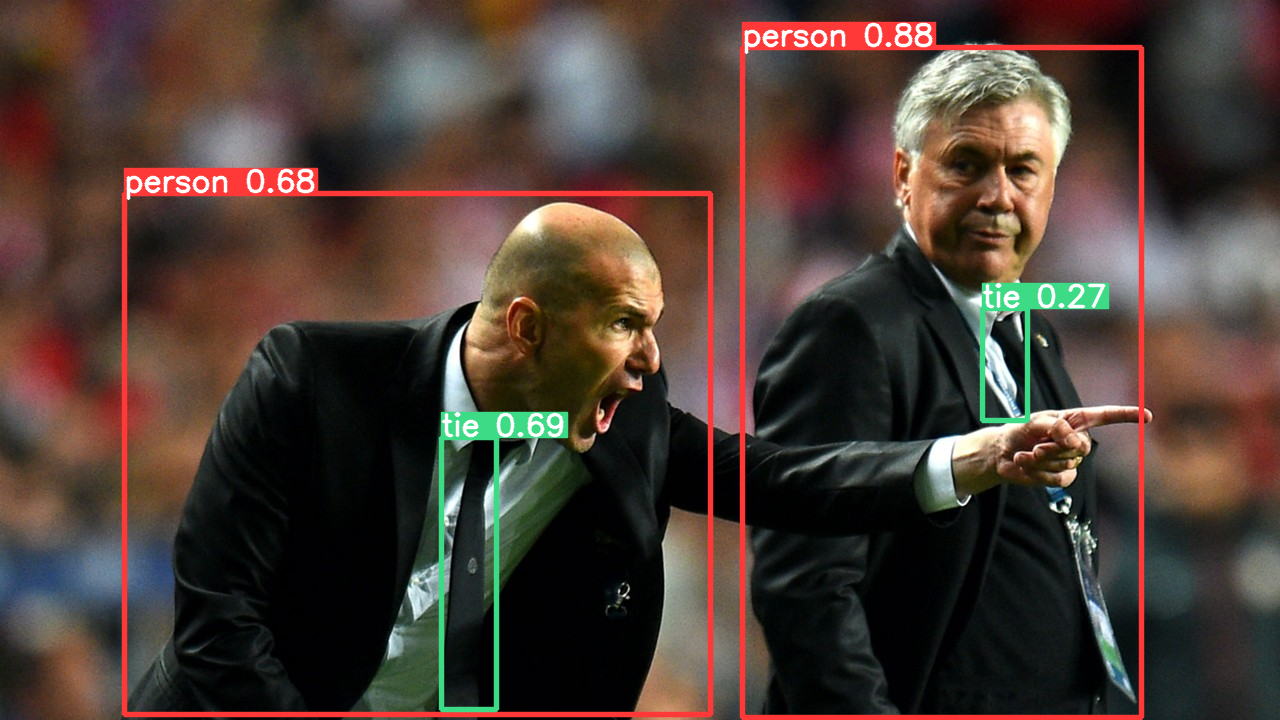

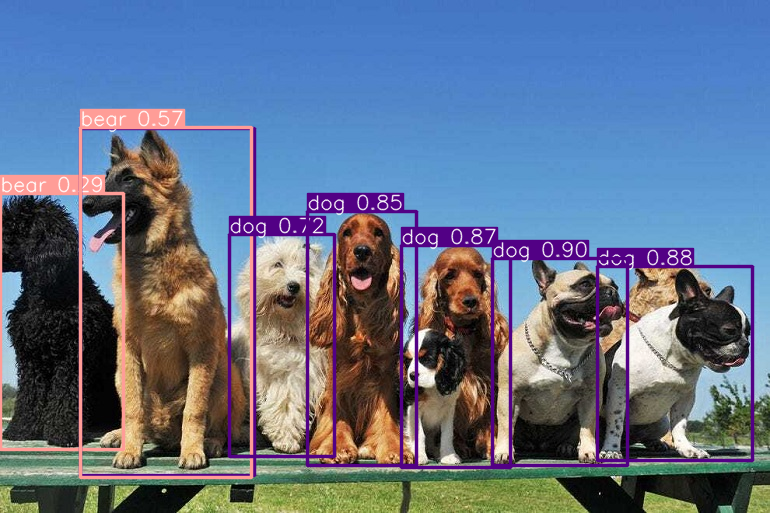

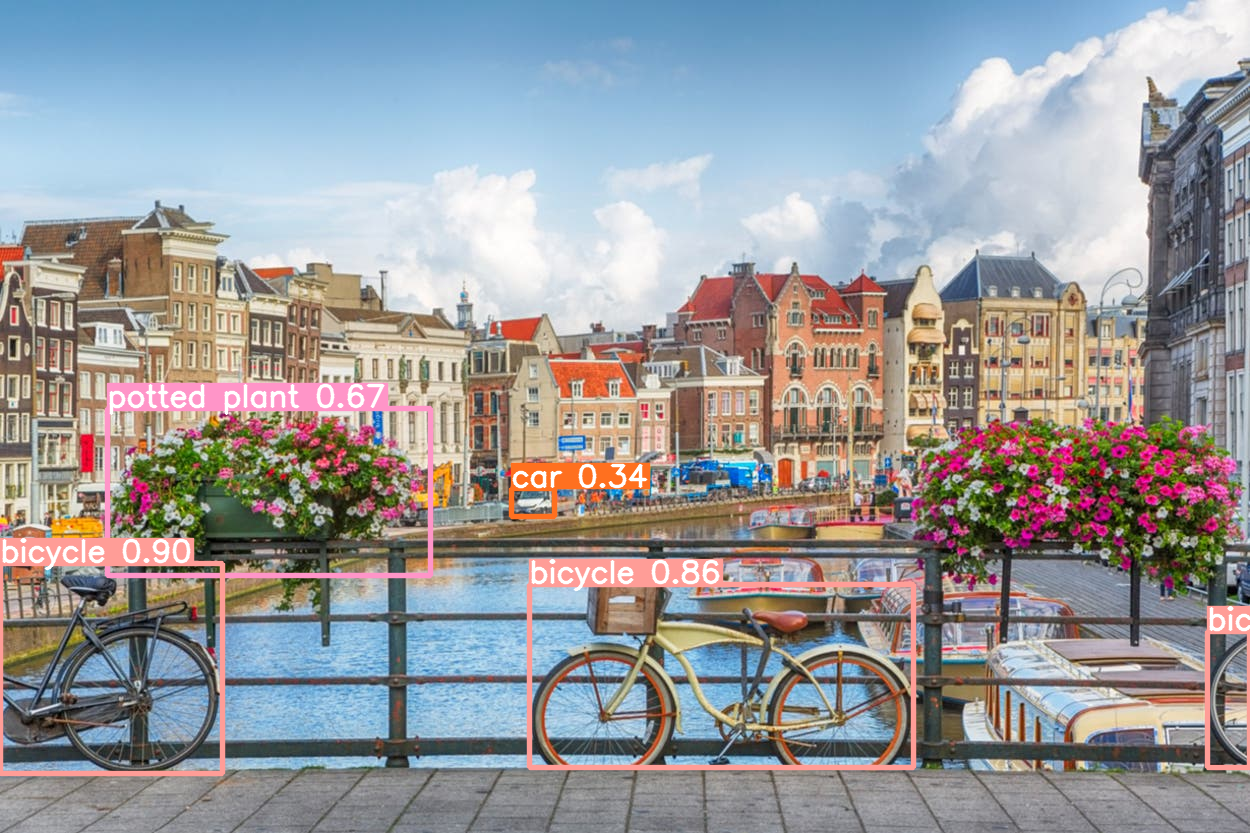

In [ ]:
#from ultralytics import render_result
import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Images
imgs = ['https://ultralytics.com/images/zidane.jpg', 
        'https://worldanimalfoundation.org/wp-content/uploads/2023/02/how-many-dogs-are-in-the-world-review-1.jpg',
        'https://static.independent.co.uk/2023/10/12/16/newFile-1.jpg?quality=75&width=1250&crop=3%3A2%2Csmart&auto=webp']  # batch of images

# Inference
results = model(imgs)

# Results
print(results.pandas().xyxy[0])
results.show()

# Внутри - не магия, а модель на pytorch

In [ ]:
print('Модель - это pythorch.nn.module:', isinstance(model, nn.Module), '\n')

print(model)

Модель - это pythorch.nn.module: True 

AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 3

И трансформеры тут тоже есть: [Swin Transformer: Hierarchical Vision Transformer using Shifted Windows](https://arxiv.org/abs/2103.14030). Swin - потому что **S**hifted **wind**ows. Русскоязычный разбор есть на [хабре](https://habr.com/ru/articles/599057/)

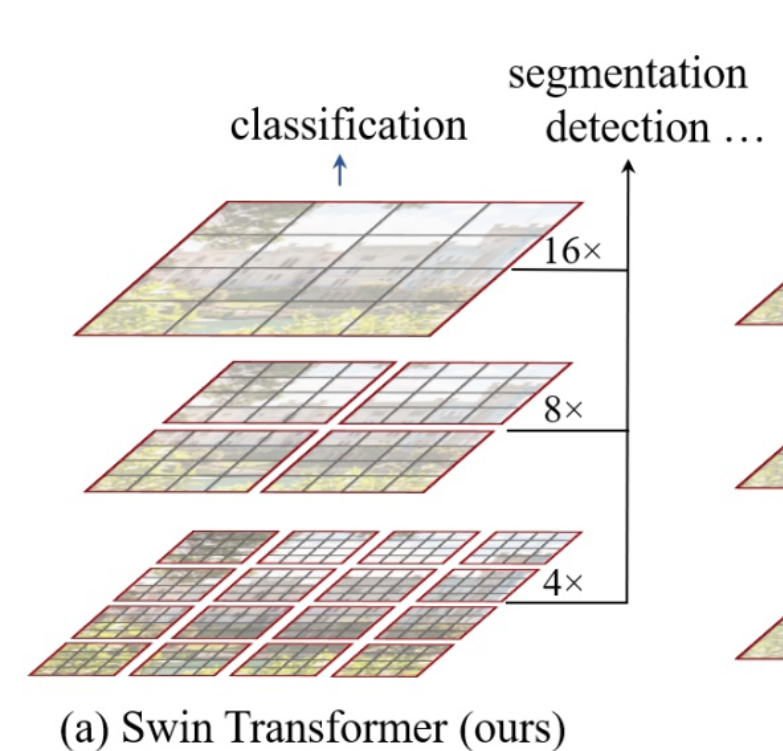

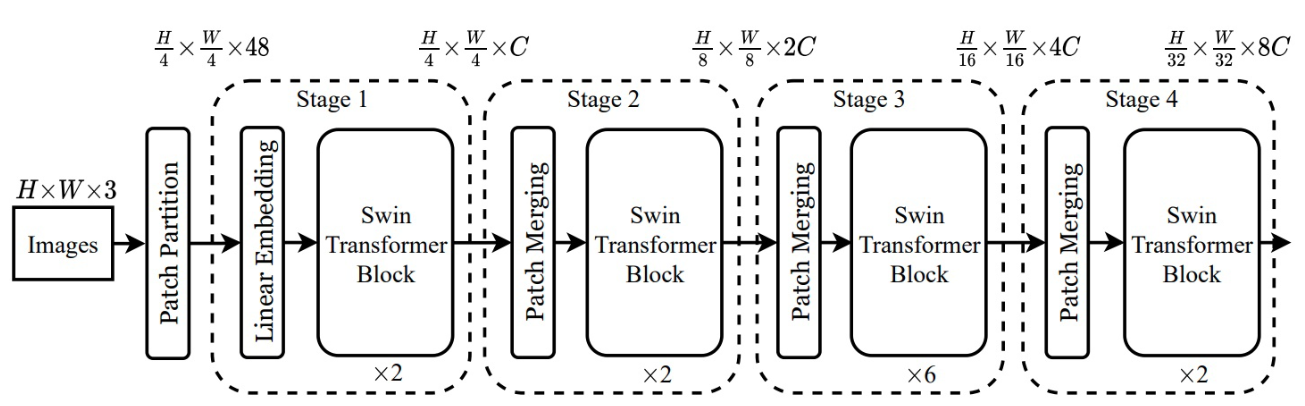